In [1]:
import random
import numpy as np

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")


# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# List physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())

2024-06-09 01:13:43.584422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 01:13:43.584512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 01:13:43.769217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0
Keras Version: 3.3.3


In [2]:

seed = random.randint(0, 1000)

# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 245


In [3]:
# Management Modules
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter

# Data loading and transformation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-trained models
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception

# Model Layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hyertunig and Metrices
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Specify the root file path
directory_path = "/kaggle/input/salmonscan/SalmonScan/Augmented/"
N_CLASSES = 2
IMAGE_SIZE = (224,224,3)
epochs= 50

In [5]:
def create_callbacks(name, patience):
    return [
        EarlyStopping(patience=patience, restore_best_weights=True, verbose=1),
        ModelCheckpoint(name + ".h5", save_best_only=True, monitor="val_loss")
    ]

In [6]:
# Collect the class names
class_names = os.listdir(directory_path)

# Show the information
print(f"Number of Classes: {N_CLASSES}")
print("Class Names:")
for index, name in enumerate(class_names):
    print(f"{index + 1:2}. {name}")

Number of Classes: 2
Class Names:
 1. InfectedFish
 2. FreshFish


In [7]:
# Compute the sample size for each class
class_sample_size = [len(os.listdir(directory_path + class_name))
                     for class_name in class_names]

# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images *
                          100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

# Calculate the rank of each class based on data size
class_distribution_df["Rank"] = class_distribution_df["Data Size"].rank(
    method="dense", ascending=False)

# Show the data
class_distribution_df

,Class Names,Data Size,Percentage(%),Rank
0,InfectedFish,752,62.251656,1.0
1,FreshFish,456,37.748344,2.0


In [8]:
# Visualize the class distribution
fig = px.bar(
    data_frame=class_distribution_df,
    x="Class Names",
    y="Data Size",
    text="Data Size",
    hover_data=["Percentage(%)", "Rank"],
    title="Class Distribution of Insects in the Dataset",
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
)

# Set axis labels and adjust layout
fig.update_layout(
    xaxis_title="Class Names",
    yaxis_title="Data Size",
    yaxis_tickformat="d",
    yaxis=dict(showgrid=False),
    showlegend=False,
)

# Show the plot
fig.show()

In [9]:


# Computer class weights.
class_weights = [total_n_images / (N_CLASSES * class_samples)
                 for class_samples in class_sample_size]

# Add this data into the data frame
class_distribution_df["Class Weights"] = class_weights

# Show the updated data
class_distribution_df



,Class Names,Data Size,Percentage(%),Rank,Class Weights
0,InfectedFish,752,62.251656,1.0,0.803191
1,FreshFish,456,37.748344,2.0,1.324561


In [10]:
# Initialize empty lists to collect image paths and class labels
all_image_paths = []
class_labels = []

# Collect all image paths and corresponding class labels
for class_name in class_names:
    paths = glob(directory_path + f"{class_name}/*")
    all_image_paths.extend(paths)
    class_labels.extend([class_name] * len(paths))

# Perform stratified data split
train_images, valid_test_images = train_test_split(
    all_image_paths, train_size=0.8, test_size=0.2, stratify=class_labels)
valid_images, test_images = train_test_split(
    valid_test_images, train_size=0.9, test_size=0.1)

In [11]:
# Extract class labels for trained images
trained_class_labels = [os.path.split(path)[0].split("/")[-1] for path in train_images]

# Compute class distribution
class_distribution = dict(Counter(trained_class_labels))

# Compute class weights
total_trained_images = len(train_images)
train_class_weights = {class_label: total_trained_images /
                       (N_CLASSES * class_samples) for class_label, class_samples in class_distribution.items()}

# Display the class weights of the training images
print(f"  Class Name {' '*27} Train Class Weight {' '} Original Class Weights")
for index, (name, weight) in enumerate(train_class_weights.items()):
    original_weight = class_distribution_df[class_distribution_df["Class Names"]
                                            == name]["Class Weights"].values[0]
    print(f"{index+1:2}. {name:40} {weight:.3f} {original_weight:25.3f}")

  Class Name                             Train Class Weight   Original Class Weights
 1. FreshFish                                1.323                     1.325
 2. InfectedFish                             0.804                     0.803


In [12]:
class FarmInsects:
    """
    A class for loading and processing farm insect images dataset.
    """

    def __init__(self, class_names: list, n_classes: int, image_size: tuple = (256, 256, 3)):
        """
        Initialize FarmInsects class.

        Args:
            class_names (list): List of class names.
            n_classes (int): Number of classes.
            image_size (tuple): Size of the images (height, width, channels).
        """
        self.image_size = image_size
        self.class_names = class_names
        self.n_classes = n_classes

    def load_image(self, image_path: str) -> tf.Tensor:
        """
        Load and preprocess an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            tf.Tensor: Preprocessed image tensor.
        """
        image_file = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_file, channels=3)
        image = tf.image.resize(image, self.image_size[:2])
        image = image / 255.

        return image

    def extract_label(self, image_path: str, names: bool = False) -> int or str:
        """
        Extract the label from the image path.

        Args:
            image_path (str): Path to the image file.
            names (bool): Whether to return class names or numerical labels.

        Returns:
            int or str: Numerical label or class name.
        """
        name = os.path.split(image_path)[0].split("/")[-1]
        if names:
            return name
        else:
            label = self.class_names.index(name)
            return label

    def load_data(self, image_paths: list, desc: str = "Loading", one_hot: bool = True, names: bool = False) -> tuple:
        """
        Load the images and labels from the given image paths.

        Args:
            image_paths (list): List of image paths.
            desc (str): Description for tqdm progress bar.
            one_hot (bool): Whether to use one-hot encoding for labels.
            names (bool): Whether to return class names instead of numerical labels.

        Returns:
            tuple: Tuple containing the loaded images and labels.
        """
        self.images = np.empty((len(image_paths),) + self.image_size, dtype=np.float32)

        if names:
            self.labels = []
        else:
            self.labels = np.empty((len(image_paths),), dtype=np.int32)

        for index, path in tqdm(enumerate(image_paths), desc=desc):
            image = self.load_image(image_path=path)
            label = self.extract_label(image_path=path, names=names)
            self.images[index] = image

            if names:
                self.labels.append(label)
            else:
                self.labels[index] = label

        if one_hot and not names:
            one_hot_labels = tf.one_hot(self.labels, depth=self.n_classes)
            return self.images, one_hot_labels
        else:
            return self.images, self.labels

    def show_random_images(self, grid: tuple, image_paths: list, figsize: tuple = (25, 20)):
        """
        Display random images from the given image paths.

        Args:
            grid (tuple): Tuple specifying the grid size (number of rows, number of columns).
            image_paths (list): List of image paths.
            figsize (tuple): Figure size for displaying the images.
        """
        n_rows, n_cols = grid
        n_images = n_rows * n_cols

        image_indexes = np.random.randint(0, len(image_paths), size=n_images)
        image_paths = np.take(image_paths, image_indexes)

        images, labels = self.load_data(image_paths=image_paths, one_hot=False, names=True)

        plt.figure(figsize=figsize)

        for plot_index in range(1, n_images + 1):
            plt.subplot(n_rows, n_cols, plot_index)
            plt.imshow(images[plot_index - 1])
            plt.title(label=labels[plot_index - 1])
            plt.axis('off')

        plt.show()

In [13]:
# Initialize dataset
farm_data = FarmInsects(class_names=class_names, n_classes=N_CLASSES, image_size=IMAGE_SIZE)

# Load Training Data
trainXs, trainYs = farm_data.load_data(image_paths=train_images, desc="Training Data")

# Load testing Data
testXs, testYs = farm_data.load_data(image_paths=test_images, desc="Testing Data")

# Load validation Data
validXs, validYs = farm_data.load_data(image_paths=valid_images, desc="Validation Data")

Training Data: 966it [00:09, 100.98it/s]
Testing Data: 25it [00:00, 108.25it/s]
Validation Data: 217it [00:02, 104.30it/s]


Loading: 25it [00:00, 170.00it/s]


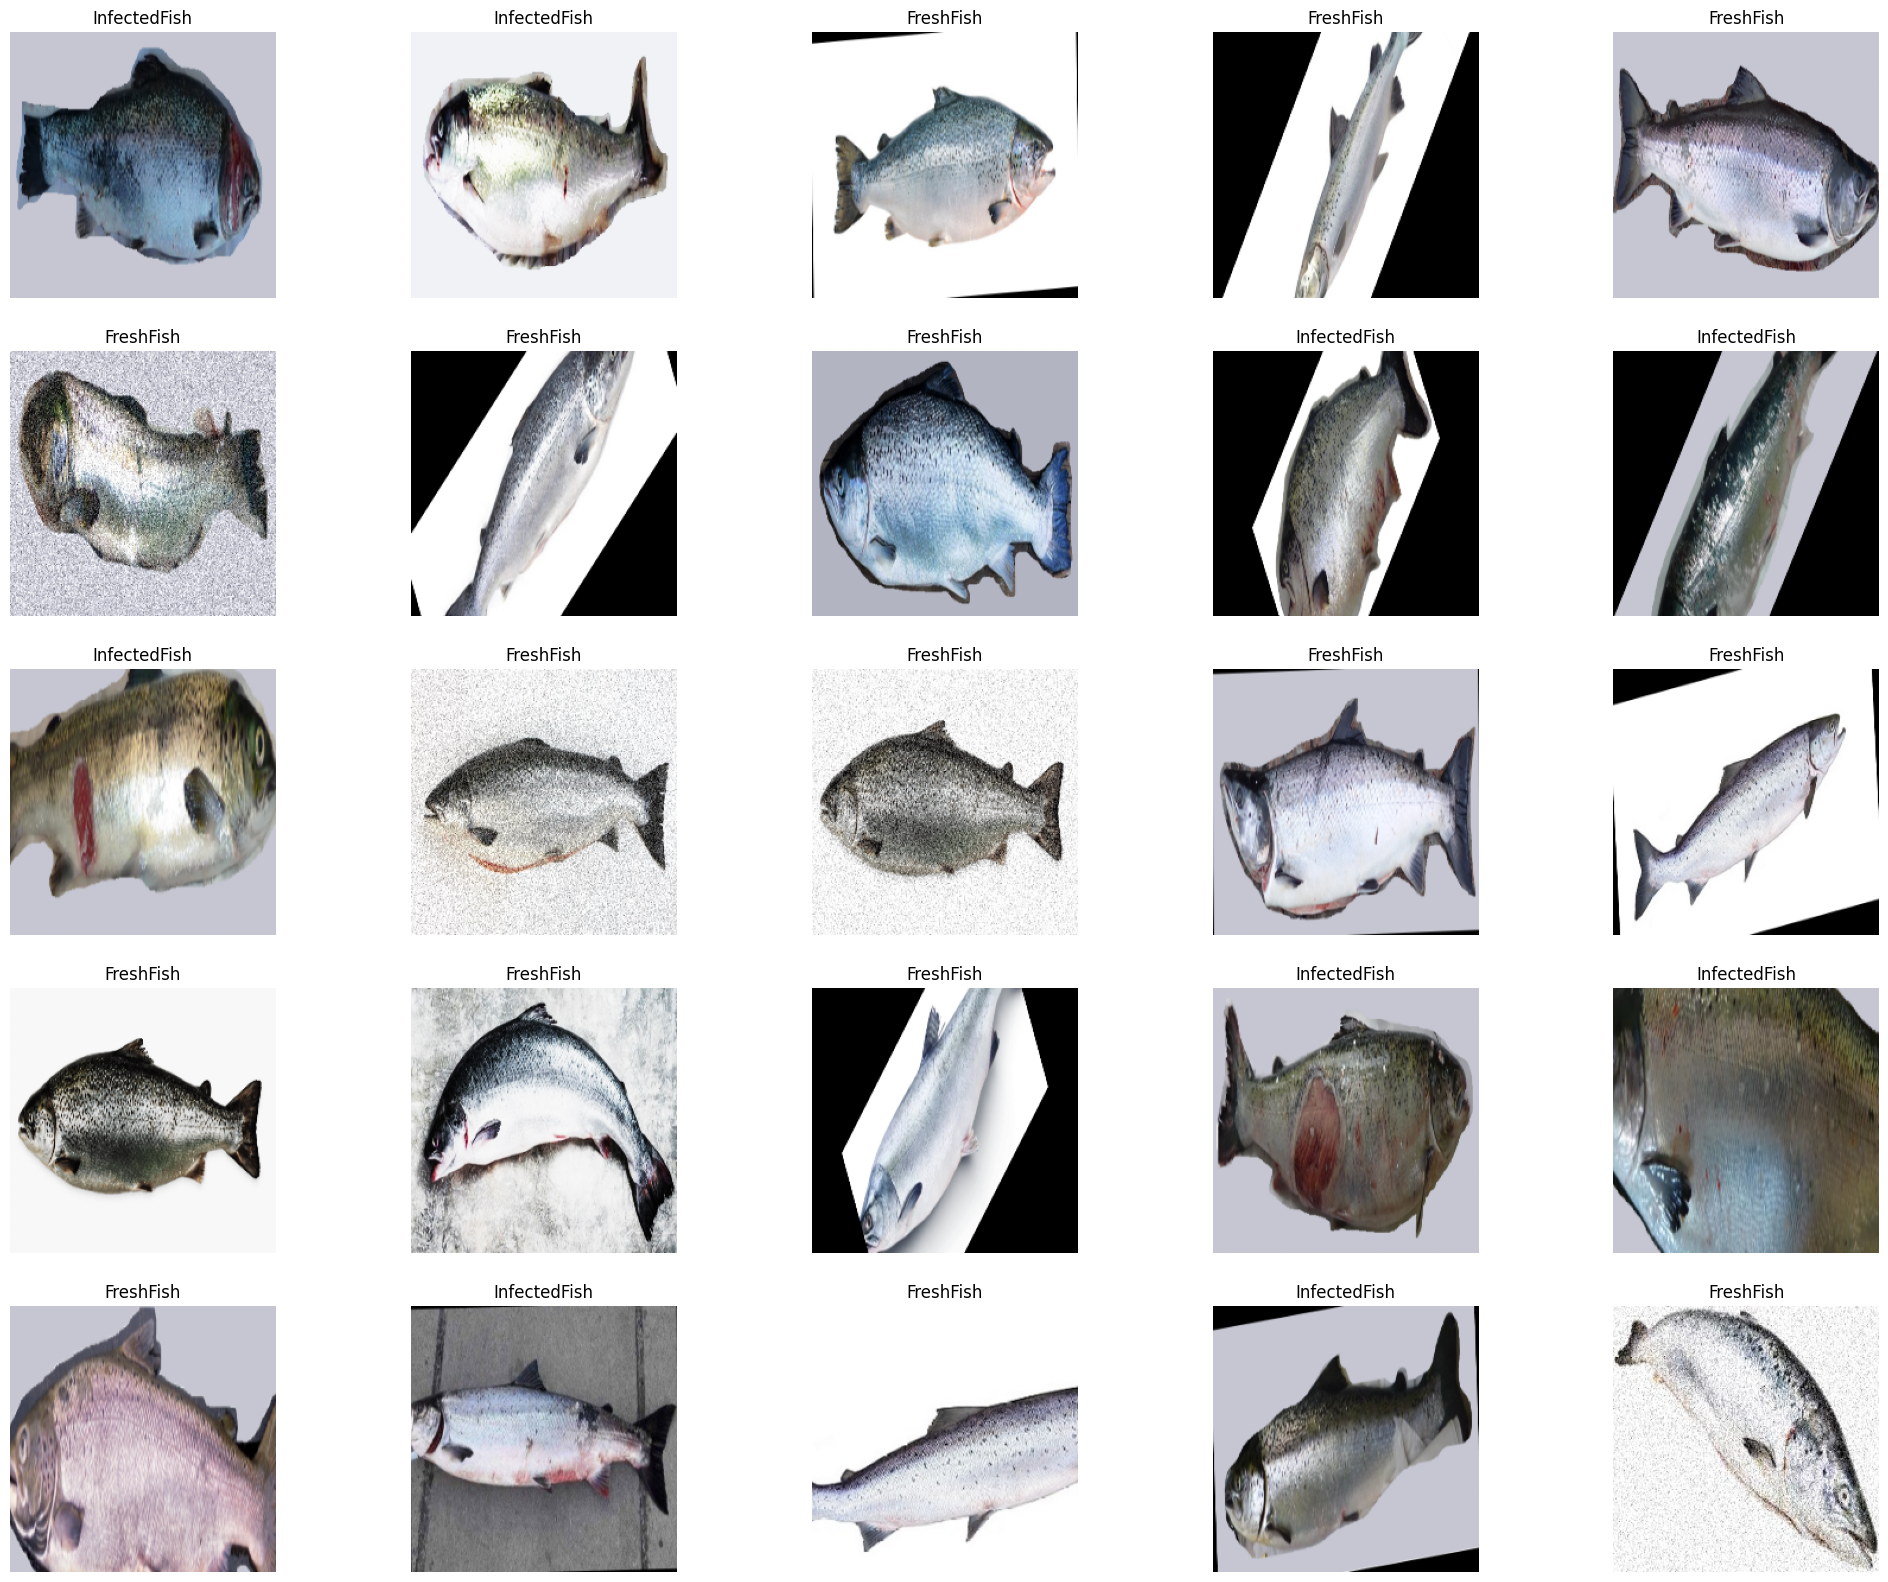

In [14]:
# Using in-built method
farm_data.show_random_images(image_paths=train_images, grid=(5,5))

In [15]:
# Converting the class weights from a list to dictionary
class_weights_dict = dict(zip(range(N_CLASSES), class_distribution_df["Class Weights"]))
class_weights_dict

{0: 0.8031914893617021, 1: 1.3245614035087718}

In [16]:
class Model:
    models = [
        ResNet50V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        ResNet152V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
    ]

    model_names = [
        "ResNet50V2",
        "ResNet152V2",
        "MobileNetV2",
        "Xception"
    ]

    def __init__(self, model_name: str):
        """
        Initialize the Model class with the specified pre-trained model.
        
        Args:
            model_name (str): Name of the pre-trained model to be used.
        """
        self.model_name = model_name
        self.index = self.model_names.index(model_name)
        self.backbone = self.models[self.index]

    def train(self, trainXs, trainYs, validation_data, epochs=epochs, batch_size=32, verbose=1):
        """
        Train the model using the specified training and validation data.
        
        Args:
            trainXs (numpy.ndarray): Training images.
            trainYs (numpy.ndarray): Training labels.
            validation_data: Validation data as a tuple (valXs, valYs).
            epochs (int): Number of epochs to train the model.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training logs (0, 1, or 2).
        """
        self.backbone.trainable = False

        self.model = Sequential([
            self.backbone,
            GlobalAveragePooling2D(),
            Dropout(0.4),
            Dense(256, activation='relu'),            
            Dense(128, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            trainXs, trainYs,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights_dict,
            steps_per_epoch=len(trainXs)//batch_size,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=verbose
        )

    def visualize_training(self):
        """
        Visualize the training history.
        """
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{self.model_name} Training Curve")

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label="Loss", color="g")
        plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (crossentropy)")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
        plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()

        plt.show()
    
    def evaluate(self, testXs, testYs, verbose=1, visualize=False):
        
        test_loss, test_acc = self.model.evaluate(testXs, testYs, verbose=verbose)
        
        if visualize:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{self.model_name} Performance Check")
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['loss'], label="Loss", color="g")
            plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
            plt.axhline(test_loss, color='black', alpha=0.8, linestyle="--", label="Test Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss (crossentropy)")
            plt.grid()
            plt.ylim([0, 1.5])
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
            plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
            plt.axhline(test_acc, color='black', alpha=0.8, linestyle="--", label="Test Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0.4, 1.0])
            plt.grid()
            plt.legend()

            plt.show()
        else:
            return test_loss, test_acc

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 10:01 21s/step - accuracy: 0.5312 - loss: 0.7230

I0000 00:00:1717895685.788694     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717895685.832823     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7660 - loss: 0.5229

W0000 00:00:1717895691.797737     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717895700.975807     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step - accuracy: 0.7675 - loss: 0.5207 - val_accuracy: 0.8894 - val_loss: 0.2210
Epoch 2/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:52 8s/step - accuracy: 1.0000 - loss: 0.1640

W0000 00:00:1717895709.339252     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 1.0000 - loss: 0.1640 - val_accuracy: 0.9078 - val_loss: 0.1996
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9241 - loss: 0.2010 - val_accuracy: 0.8848 - val_loss: 0.2089
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0401 - val_accuracy: 0.9032 - val_loss: 0.1961
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9362 - loss: 0.1585 - val_accuracy: 0.9124 - val_loss: 0.1777
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 0.9171 - val_loss: 0.1660
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9447 - loss: 0.1269 - val_accuracy: 0.8894 - val_loss: 0.2140
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8333 - loss: 0.1966 - val_accuracy: 0.9032 - val_loss: 0.1850
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9570 - loss: 0.1027 - val_accuracy: 0.9078 - val_loss: 0.

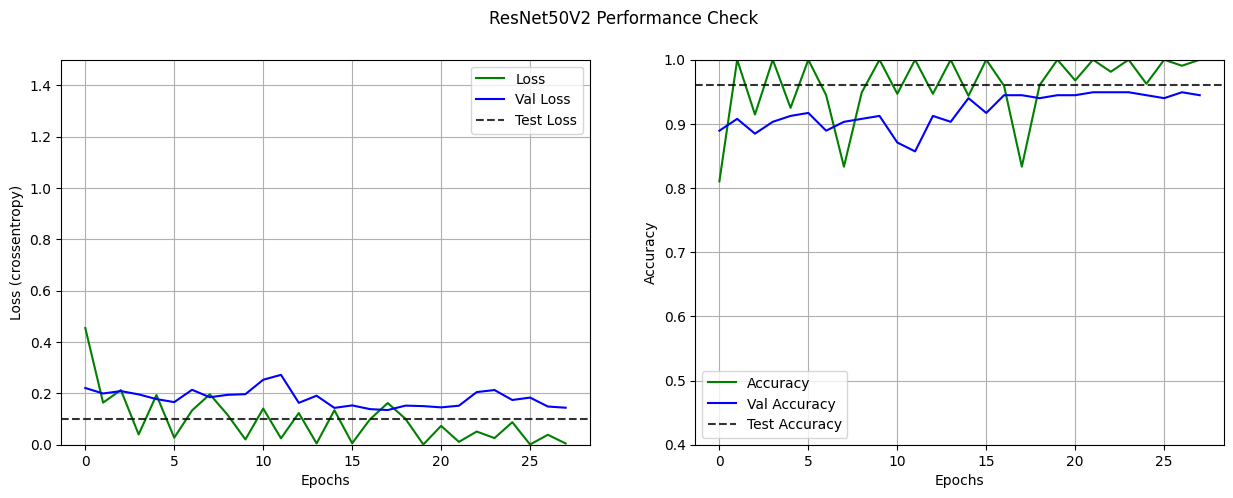

In [17]:
# Initialize the ResNet50V2 model
resnet50_model = Model(model_name="ResNet50V2")

# Train the model
resnet50_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
resnet50_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 12:39 26s/step - accuracy: 0.6562 - loss: 0.7362

W0000 00:00:1717895777.973118     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7643 - loss: 0.5690

W0000 00:00:1717895793.102341     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717895798.503320     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 736ms/step - accuracy: 0.7660 - loss: 0.5648 - val_accuracy: 0.9078 - val_loss: 0.2400
Epoch 2/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:47 8s/step - accuracy: 0.8333 - loss: 0.2726

W0000 00:00:1717895807.317518     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8333 - loss: 0.2726 - val_accuracy: 0.9171 - val_loss: 0.2349
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9264 - loss: 0.1998 - val_accuracy: 0.9032 - val_loss: 0.2272
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 0.0529 - val_accuracy: 0.9217 - val_loss: 0.1989
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9491 - loss: 0.1372 - val_accuracy: 0.9309 - val_loss: 0.1805
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.9355 - val_loss: 0.1921
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.9674 - loss: 0.0923 - val_accuracy: 0.9263 - val_loss: 0.1846
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9263 - val_loss: 0.1865
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.9678 - loss: 0.0863 - val_accuracy: 0.9078 - val_los

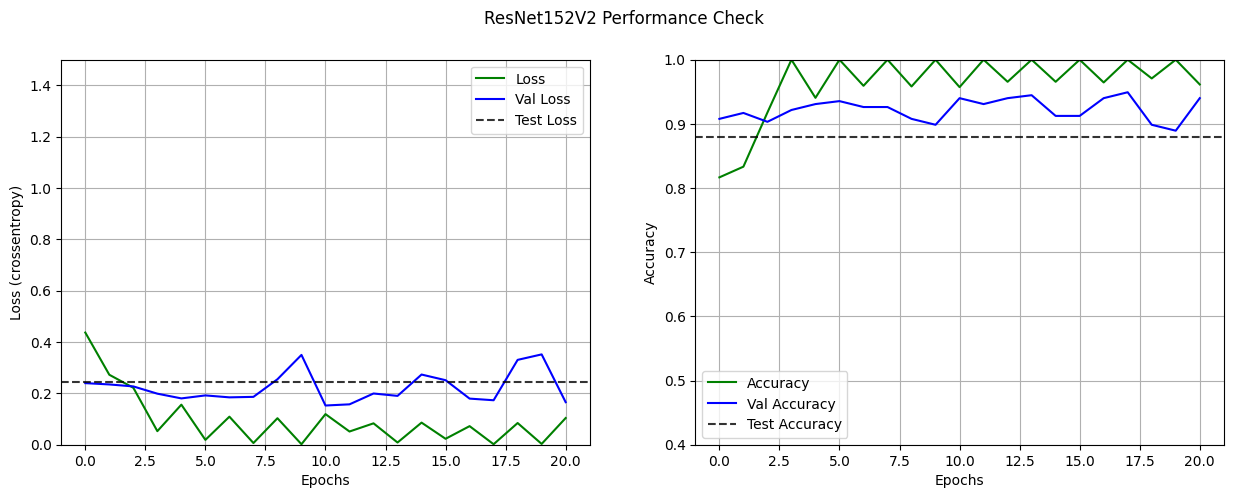

In [18]:
# Initialize the ResNet152V2 model
resnet152_model = Model(model_name="ResNet152V2")

# Train the model
resnet152_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
resnet152_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
 5/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6511 - loss: 0.6434

W0000 00:00:1717895910.511800     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7379 - loss: 0.5260

W0000 00:00:1717895914.935400     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.7417 - loss: 0.5225 - val_accuracy: 0.8894 - val_loss: 0.2591
Epoch 2/50


W0000 00:00:1717895921.068088     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: 0.1419 - val_accuracy: 0.8756 - val_loss: 0.2934
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8901 - loss: 0.2657 - val_accuracy: 0.8848 - val_loss: 0.2780
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8333 - loss: 0.2768 - val_accuracy: 0.9032 - val_loss: 0.2079
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9396 - loss: 0.1747 - val_accuracy: 0.9032 - val_loss: 0.2417
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0288 - val_accuracy: 0.9078 - val_loss: 0.2016
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9312 - loss: 0.1501 - val_accuracy: 0.9032 - val_loss: 0.2264
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 0.9263 - val_loss: 0.1801
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9396 - loss: 0.1361 - val_accuracy: 0.9124 - val_loss: 0.

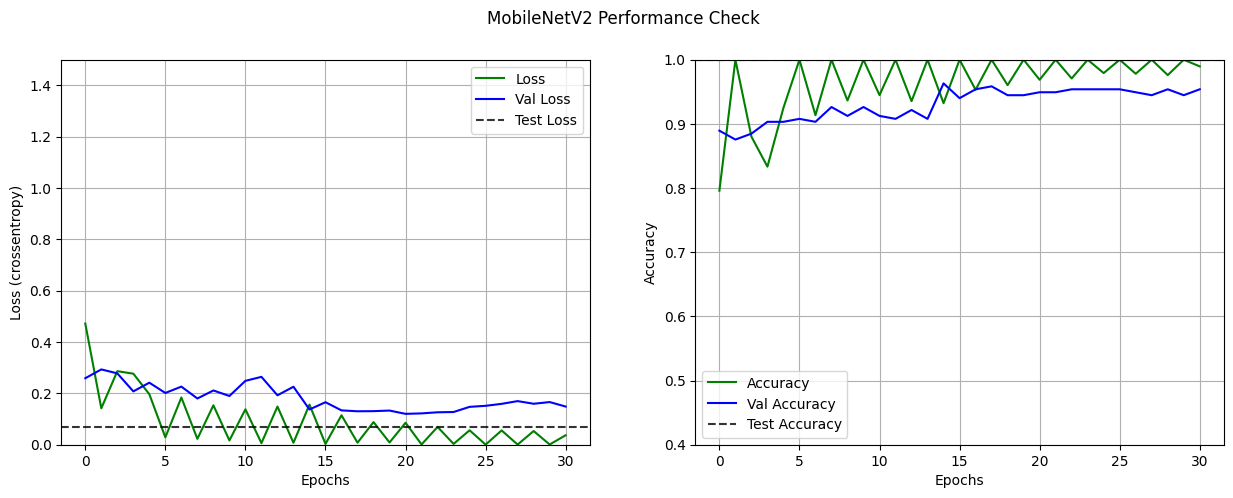

In [19]:
# Initialize the MobileNetV2 model
mobilenetv2_model = Model(model_name="MobileNetV2")

# Train the model
mobilenetv2_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
mobilenetv2_model.evaluate(testXs, testYs, visualize=True, verbose=1)

Epoch 1/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 10:39 22s/step - accuracy: 0.5938 - loss: 0.7885

W0000 00:00:1717895972.931705     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7036 - loss: 0.5895

W0000 00:00:1717895980.411906     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717895993.502089     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 714ms/step - accuracy: 0.7058 - loss: 0.5858 - val_accuracy: 0.9124 - val_loss: 0.2511
Epoch 2/50
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:28 7s/step - accuracy: 1.0000 - loss: 0.1053

W0000 00:00:1717896000.963628     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 1.0000 - loss: 0.1053 - val_accuracy: 0.8940 - val_loss: 0.2438
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9137 - loss: 0.2521 - val_accuracy: 0.9078 - val_loss: 0.2035
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0534 - val_accuracy: 0.9217 - val_loss: 0.1995
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9196 - loss: 0.1990 - val_accuracy: 0.9078 - val_loss: 0.2194
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 0.9032 - val_loss: 0.1999
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9594 - loss: 0.1392 - val_accuracy: 0.9078 - val_loss: 0.1972
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9124 - val_loss: 0.1915
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9409 - loss: 0.1451 - val_accuracy: 0.9032 - val_loss

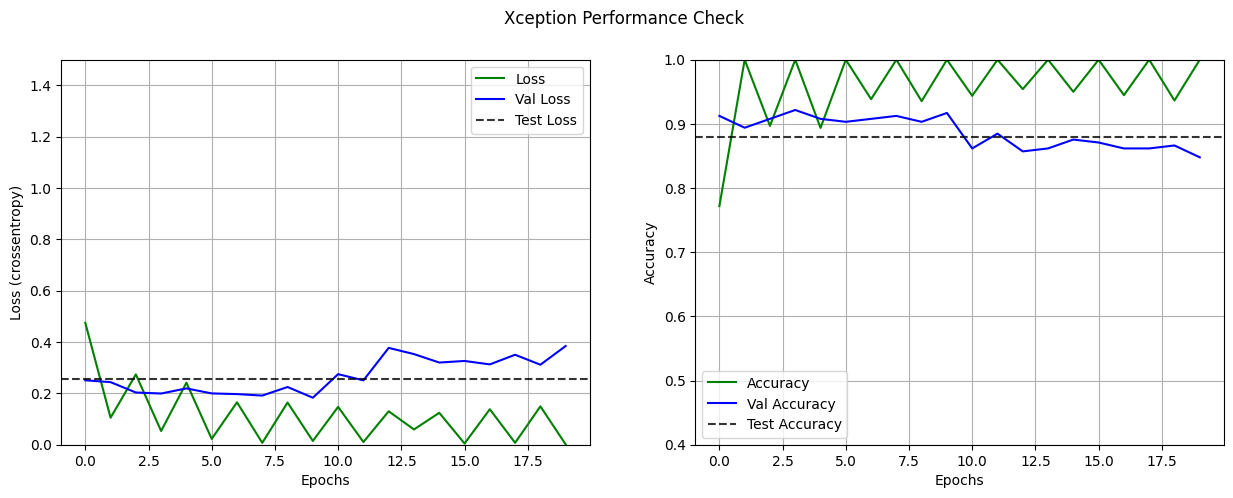

In [20]:
# Initialize the Xception model
xception_model = Model(model_name="Xception")

# Train the model
xception_model.train( 
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=1,
)

# Evaluate model performance on testing data.
xception_model.evaluate(testXs, testYs, visualize=True, verbose=1)

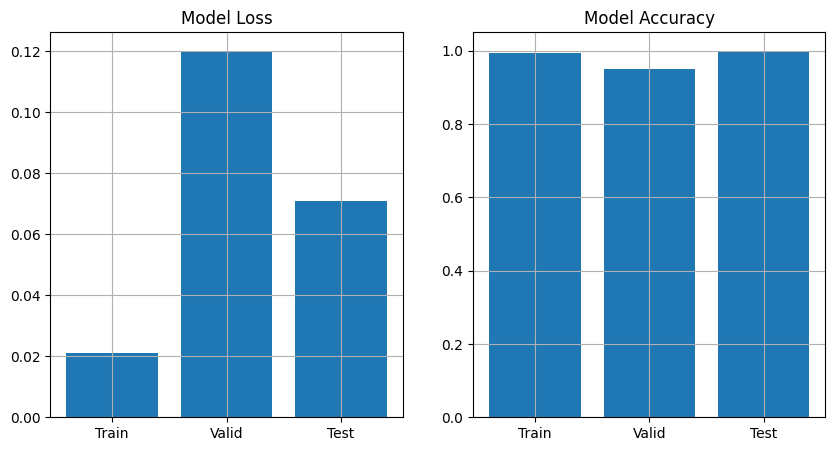

In [24]:
# Model evaluation
train_loss, train_acc = mobilenetv2_model.evaluate(trainXs, trainYs, verbose=0)
valid_loss, valid_acc =mobilenetv2_model.evaluate(validXs, validYs, verbose=0)
test_loss, test_acc = mobilenetv2_model.evaluate(testXs, testYs, verbose=0)

# Visualizing Model Performance
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.bar(["Train", "Valid", "Test"], [train_loss, valid_loss, test_loss])
plt.grid()

plt.subplot(1,2,2)
plt.title("Model Accuracy")
plt.bar(["Train", "Valid", "Test"], [train_acc, valid_acc, test_acc])
plt.grid()

plt.show()